# RSSIデータを用いた場所分類

`data/` ディレクトリにあるRSSIデータ（ファイル名に場所が含まれる）を読み込み、1分間のRSSIデータパターンから場所を分類するモデルを構築します。

## 1. ライブラリのインポート

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import joblib # モデル保存用
import japanize_matplotlib

## 2. データの読み込みと前処理

`data/` ディレクトリ内の全CSVファイルを読み込み、ファイル名からクラスラベル（場所）を抽出します。
その後、絶対時刻をdatetime型に変換します。

In [2]:
data_dir = Path('data')
all_files = list(data_dir.glob('*.csv'))

all_dfs = []
for f in all_files:
    # ファイル名からクラスラベル（場所）を抽出 (例: 202504261747_クローゼット.csv -> クローゼット)
    match = re.search(r'_(.+)\.csv', f.name)
    if match:
        location = match.group(1)
        try:
            df = pd.read_csv(f)
            # datetime列が存在し、内容があるか確認
            if 'datetime' in df.columns and not df['datetime'].isnull().all():
                df['location'] = location
                # datetime列をdatetime型に変換 (エラーは無視してNaTにする)
                df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce')
                # time_s, rssi_dbm列が存在するか確認
                if 'time_s' in df.columns and 'rssi_dbm' in df.columns:
                     # NaTになった行を削除
                    df.dropna(subset=['datetime'], inplace=True)
                    if not df.empty:
                       all_dfs.append(df[['datetime', 'rssi_dbm', 'location']])
                    else:
                        print(f"[WARN] No valid datetime entries in {f.name} after conversion.")
                else:
                    print(f"[WARN] 'time_s' or 'rssi_dbm' column missing in {f.name}. Skipping.")
            else:
                 print(f"[WARN] 'datetime' column missing or empty in {f.name}. Skipping.")
        except Exception as e:
            print(f"[ERROR] Failed to read or process {f.name}: {e}")
    else:
        print(f"[WARN] Could not extract location from filename: {f.name}. Skipping.")

if not all_dfs:
    print("[ERROR] No valid data found in CSV files. Exiting.")
    # ここで処理を中断するか、空のDataFrameを作成するかを決定
    # exit() # スクリプトの場合
    data = pd.DataFrame(columns=['datetime', 'rssi_dbm', 'location'])
else:
    data = pd.concat(all_dfs, ignore_index=True)
    # datetimeでソート
    data = data.sort_values(by='datetime').reset_index(drop=True)

print(f"Total records loaded: {len(data)}")
print("Unique locations:", data['location'].unique())
data.head()

Total records loaded: 39440
Unique locations: ['クローゼット' 'キャットタワー' 'キッチン' 'リビング' '書斎' '寝室前廊下' 'ベッド下']


,datetime,rssi_dbm,location
0,2025-04-26 17:31:12.913,-65,クローゼット
1,2025-04-26 17:31:12.915,-64,クローゼット
2,2025-04-26 17:31:13.223,-63,クローゼット
3,2025-04-26 17:31:13.225,-62,クローゼット
4,2025-04-26 17:31:13.542,-65,クローゼット


### 2.1 データのサンプリング

データを1分ごとのウィンドウに分割し、各ウィンドウに **MIN_POINTS_PER_WINDOW** 以上のデータポイントが含まれるものを1サンプルとします。
各サンプルから特徴量（RSSIの平均、標準偏差、最小値、最大値など）を抽出します。

In [3]:
# サンプリングウィンドウ内の最小データポイント数
MIN_POINTS_PER_WINDOW = 5

# datetimeをインデックスに設定
if not data.empty and 'datetime' in data.columns:
    data.set_index('datetime', inplace=True)
else:
    print("[WARN] Data is empty or 'datetime' column missing before resampling.")

# 1分ごとにリサンプリングし、各ウィンドウで特徴量を計算
# Grouperを使って1分間のウィンドウを作成
def extract_features(window):
    # グローバル変数 MIN_POINTS_PER_WINDOW を参照
    if len(window) >= MIN_POINTS_PER_WINDOW:
        features = {
            'rssi_mean': window['rssi_dbm'].mean(),
            'rssi_std': window['rssi_dbm'].std(),
            'rssi_min': window['rssi_dbm'].min(),
            'rssi_max': window['rssi_dbm'].max(),
            'rssi_median': window['rssi_dbm'].median(),
            'rssi_range': window['rssi_dbm'].max() - window['rssi_dbm'].min(),
            'count': len(window),
            # location はウィンドウ内で同じはずなので最初のを取る
            'location': window['location'].iloc[0]
        }
        return pd.Series(features)
    else:
        # データポイントが閾値未満の場合はNoneを返す
        return None

if not data.empty:
    # location ごとにグループ化してからリサンプリングしないと、異なる場所のデータが混ざる可能性がある
    sampled_features_list = []
    for location, group in data.groupby('location'):
        # 1分間のウィンドウでリサンプリングし、各ウィンドウに関数を適用
        # 'T' は分単位のオフセットエイリアス
        resampler = group.resample('1T')
        features = resampler.apply(extract_features)
        # 欠損値（データが閾値未満だったウィンドウ）を削除
        features.dropna(inplace=True)
        if not features.empty:
           sampled_features_list.append(features)

    if sampled_features_list:
        sampled_data = pd.concat(sampled_features_list)
        # stdがNaNになる場合（ウィンドウ内のデータが1つの場合など）を0で埋める
        sampled_data['rssi_std'].fillna(0, inplace=True)
        print(f"Total samples after resampling (>={MIN_POINTS_PER_WINDOW} points/min): {len(sampled_data)}")
        print("Sample counts per location:")
        print(sampled_data['location'].value_counts())
        sampled_data.head()
    else:
       print(f"[WARN] No samples met the criteria (>={MIN_POINTS_PER_WINDOW} points/min).")
       sampled_data = pd.DataFrame() # 空のDataFrame
else:
    print("[WARN] Data is empty, skipping feature extraction.")
    sampled_data = pd.DataFrame() # 空のDataFrame

/var/folders/44/wbhkyx691tz9thbyj4tj75rr0000gp/T/ipykernel_7772/1278036484.py:37: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  resampler = group.resample('1T')
/var/folders/44/wbhkyx691tz9thbyj4tj75rr0000gp/T/ipykernel_7772/1278036484.py:37: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  resampler = group.resample('1T')
/var/folders/44/wbhkyx691tz9thbyj4tj75rr0000gp/T/ipykernel_7772/1278036484.py:37: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  resampler = group.resample('1T')
/var/folders/44/wbhkyx691tz9thbyj4tj75rr0000gp/T/ipykernel_7772/1278036484.py:37: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  resampler = group.resample('1T')
/var/folders/44/wbhkyx691tz9thbyj4tj75rr0000gp/T/ipykernel_7772/1278036484.py:37: FutureWarning: 'T' is deprecated and will be remov

Total samples after resampling (>=5 points/min): 988
Sample counts per location:
location
リビング       663
キッチン       117
キャットタワー    115
ベッド下        41
寝室前廊下       39
書斎           7
クローゼット       6
Name: count, dtype: int64


/var/folders/44/wbhkyx691tz9thbyj4tj75rr0000gp/T/ipykernel_7772/1278036484.py:37: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  resampler = group.resample('1T')
/var/folders/44/wbhkyx691tz9thbyj4tj75rr0000gp/T/ipykernel_7772/1278036484.py:37: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  resampler = group.resample('1T')
/var/folders/44/wbhkyx691tz9thbyj4tj75rr0000gp/T/ipykernel_7772/1278036484.py:47: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplac

## 3. EDA (探索的データ分析)

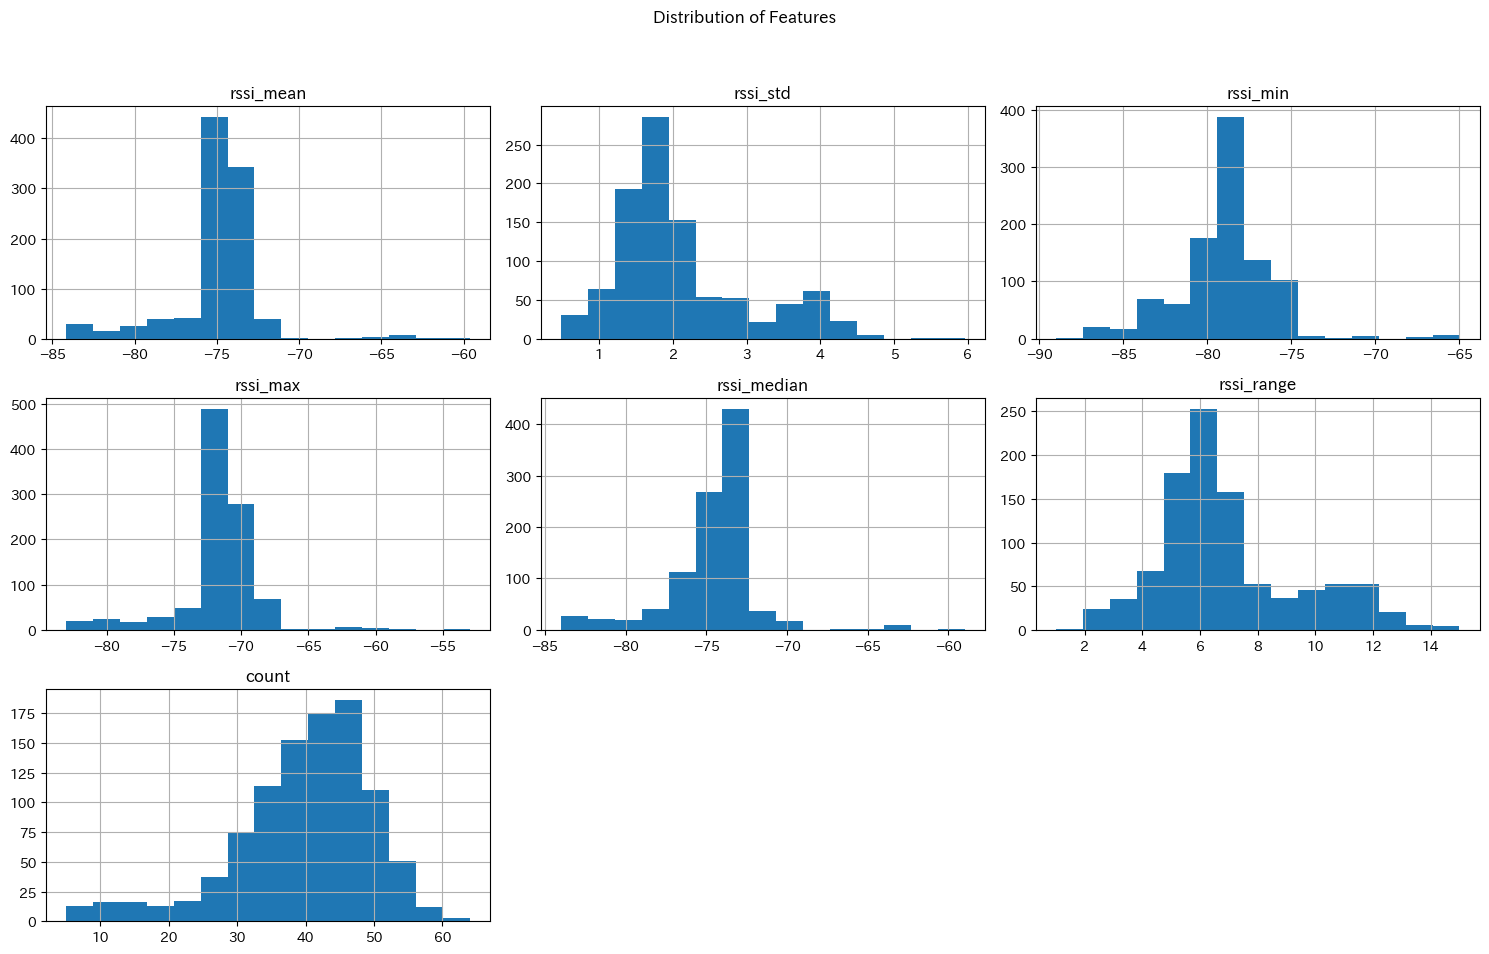

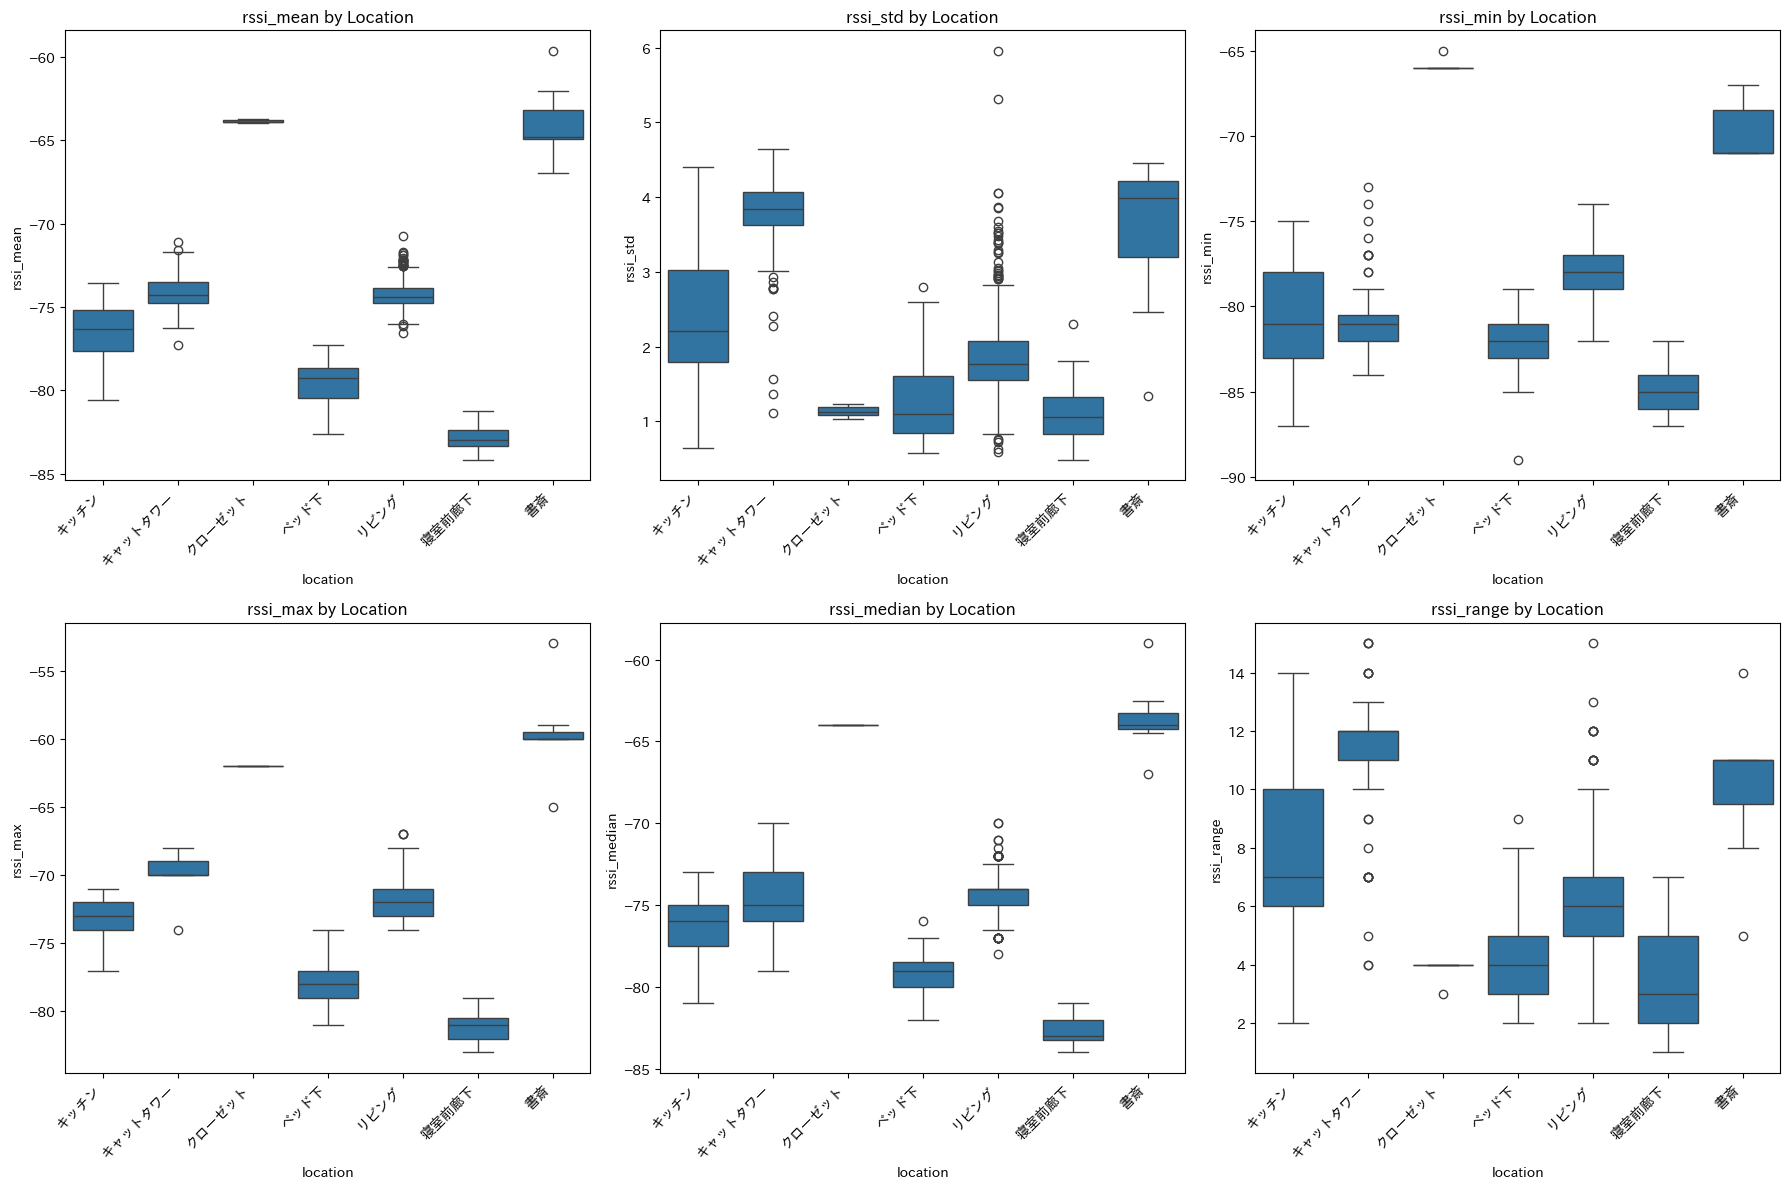

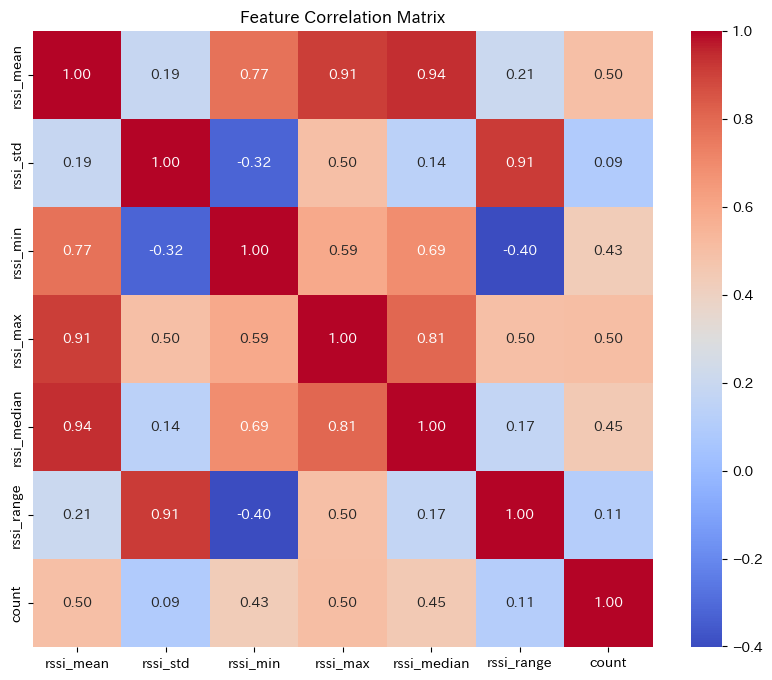

In [4]:
# sampled_dataが空でないかチェック
if not sampled_data.empty:
    # 特徴量の分布を確認 (数値型の特徴量のみ)
    numeric_features = sampled_data.select_dtypes(include=np.number).columns
    sampled_data[numeric_features].hist(bins=15, figsize=(15, 10), layout=(-1, 3))
    plt.suptitle('Distribution of Features')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
    plt.show()

    # クラスごとの特徴量の比較 (箱ひげ図)
    plt.figure(figsize=(18, 12))
    for i, feature in enumerate(numeric_features):
        if feature != 'count': # countはサンプル数なので除外することが多い
           plt.subplot(2, 3, i + 1) # レイアウト調整
           sns.boxplot(x='location', y=feature, data=sampled_data)
           plt.title(f'{feature} by Location')
           plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    # 特徴量間の相関
    plt.figure(figsize=(10, 8))
    correlation_matrix = sampled_data[numeric_features].corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Feature Correlation Matrix')
    plt.show()
else:
    print("[INFO] sampled_data is empty. Skipping EDA plots.")

## 4. モデル構築と評価

Train set size: 691
Test set size: 297

Model Evaluation:
Accuracy: 0.9428

Classification Report:
              precision    recall  f1-score   support

        キッチン       0.90      0.77      0.83        35
     キャットタワー       0.92      0.94      0.93        35
      クローゼット       1.00      1.00      1.00         2
        ベッド下       0.71      0.83      0.77        12
        リビング       0.97      0.98      0.97       199
       寝室前廊下       1.00      0.92      0.96        12
          書斎       1.00      1.00      1.00         2

    accuracy                           0.94       297
   macro avg       0.93      0.92      0.92       297
weighted avg       0.94      0.94      0.94       297



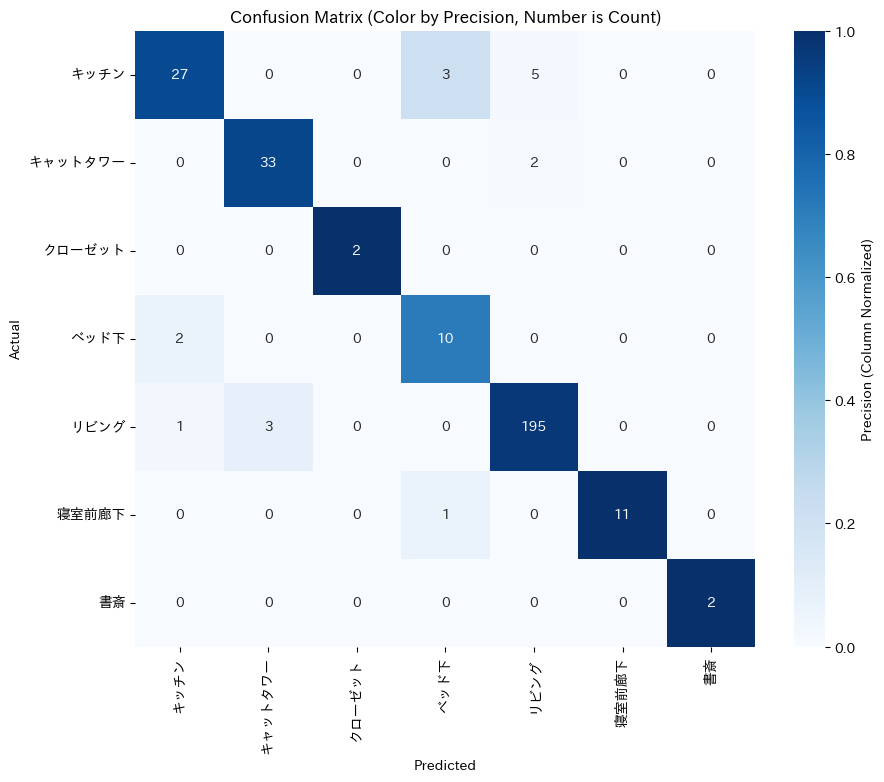

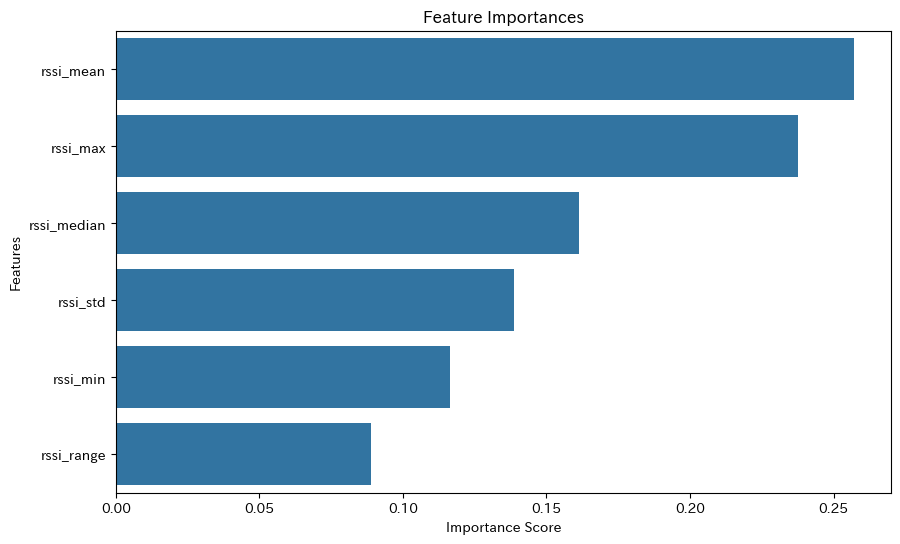


Classification bundle saved to location_classification_bundle.joblib
  Includes: model, scaler, classes, features, min_points_per_window


In [5]:
# sampled_dataが空でないかチェック
if not sampled_data.empty:
    # 特徴量 (X) とターゲット (y) に分割
    X = sampled_data.drop(['location', 'count'], axis=1) # countは特徴量として使わない場合
    y = sampled_data['location']

    # データセットをトレーニングセットとテストセットに分割
    # クラスの比率を保つために stratify=y を指定
    # 十分なサンプルがないクラスがあるとエラーになる可能性あり
    try:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
        print(f"Train set size: {X_train.shape[0]}")
        print(f"Test set size: {X_test.shape[0]}")

        # 特徴量のスケーリング
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # ランダムフォレストモデルのトレーニング
        model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
        model.fit(X_train_scaled, y_train)

        # テストデータで予測
        y_pred = model.predict(X_test_scaled)

        # モデルの評価
        print("\nModel Evaluation:")
        print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))

        # 混同行列の計算
        cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
        cm_abs = cm # 絶対数を保持

        # Precision (列方向で正規化) を計算 (ゼロ除算を避ける)
        cm_sum_col = cm.sum(axis=0, keepdims=True)
        # ゼロ除算が発生する列（合計が0）は NaN になるようにする
        with np.errstate(divide='ignore', invalid='ignore'):
            cm_precision = cm.astype('float') / cm_sum_col
            cm_precision[np.isnan(cm_precision)] = 0 # NaN は 0 に置換

        # Precisionで色付けし、絶対数値を表示
        plt.figure(figsize=(10, 8)) # サイズ調整
        sns.heatmap(cm_precision, annot=cm_abs, fmt='d', cmap='Blues',
                    xticklabels=model.classes_, yticklabels=model.classes_,
                    cbar_kws={'label': 'Precision (Column Normalized)'}) # カラーバーにラベル追加
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix (Color by Precision, Number is Count)')
        plt.show()

        # 特徴量の重要度
        feature_importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
        plt.figure(figsize=(10, 6))
        sns.barplot(x=feature_importances, y=feature_importances.index)
        plt.title('Feature Importances')
        plt.xlabel('Importance Score')
        plt.ylabel('Features')
        plt.show()

        # --- モデル、スケーラー、メタデータをまとめて保存 ---
        bundle_filename = 'location_classification_bundle.joblib'
        # MIN_POINTS_PER_WINDOW はこのセルより前のセル（サンプリング部）で定義されている想定
        bundle = {
            'model': model,
            'scaler': scaler,
            'classes': model.classes_,
            'features': X.columns.tolist(), # Indexをリストに変換
            'min_points_per_window': MIN_POINTS_PER_WINDOW
        }
        joblib.dump(bundle, bundle_filename)
        print(f"\nClassification bundle saved to {bundle_filename}")
        print(f"  Includes: model, scaler, classes, features, min_points_per_window")

    except ValueError as e:
        print(f"\n[ERROR] Could not split data or train model: {e}")
        print("This might be due to insufficient samples in one or more classes for stratification.")
    except NameError as e:
        # MIN_POINTS_PER_WINDOW が定義されていない場合のエラーハンドリング
        if 'MIN_POINTS_PER_WINDOW' in str(e):
            print(f"\n[ERROR] {e}. Please make sure the cell defining MIN_POINTS_PER_WINDOW (in section 2.1) is executed before this cell.")
        else:
            print(f"\n[ERROR] An unexpected NameError occurred: {e}")

else:
    print("[INFO] sampled_data is empty. Skipping model training and evaluation.")
